In [299]:
packages <- c('caret',
              'ggplot2',
              'flare',
              'huge',
              'tidyr'
             )

# load package is it exists, if not, install it and then load it
for (package in packages) {
    if (!require(package, character.only=TRUE, quietly=TRUE)) {
        install.packages(package, repos='http://cran.us.r-project.org')
        require(package, character.only=TRUE, quietly=TRUE)
    }
}

(.packages())

[1] "huge"      "tidyr"     "flare"     "igraph"    "Matrix"    "MASS"     
 [7] "caret"     "ggplot2"   "lattice"   "stats"     "graphics"  "grDevices"
[13] "utils"     "datasets"  "methods"   "base"

In [205]:
## generate data
n = 100
d = 1000
X = matrix(rnorm(n*d), n, d)
beta = c(10,-9,8,-7,6,-5,4,-3,2,-1,rep(0,d-10))
eps = rnorm(n)
Y = X%*%beta + 2*eps
nlamb = 25
ratio = 0.3

In [206]:
# out1 = slim(X=X,Y=Y,nlambda=nlamb,lambda.min.ratio=ratio,method="dantzig")
# out2 = slim(X=X,Y=Y,nlambda=nlamb,lambda.min.ratio=ratio,method="lq",q=1)
# out3 = slim(X=X,Y=Y,nlambda=nlamb,lambda.min.ratio=ratio,method="lq",q=1.5)
# out4 = slim(X=X,Y=Y,nlambda=nlamb,lambda.min.ratio=ratio,method="lq",q=2)
# out5 = slim(X=X,Y=Y,nlambda=nlamb,lambda.min.ratio=ratio,method="lasso")

out4 = slim(X=X,Y=Y, nlambda=50, lambda.min.ratio=1, lambda.min.value = 0.1, method="lasso",q=2)

Sparse Linear Regression with L1 Regularization.
Lasso with screening.

slim options summary: 
50 lambdas used:
 [1] 8.920 8.140 7.430 6.780 6.180 5.640 5.150 4.700 4.280 3.910 3.570 3.250
[13] 2.970 2.710 2.470 2.260 2.060 1.880 1.710 1.560 1.430 1.300 1.190 1.080
[25] 0.989 0.902 0.823 0.751 0.685 0.625 0.570 0.521 0.475 0.433 0.395 0.361
[37] 0.329 0.300 0.274 0.250 0.228 0.208 0.190 0.173 0.158 0.144 0.132 0.120
[49] 0.110 0.100
Method = lasso 
Degree of freedom: 0 -----> 82 
Runtime: 4.346535 secs 



slim options summary: 
50 lambdas used:
 [1] 8.920 8.140 7.430 6.780 6.180 5.640 5.150 4.700 4.280 3.910 3.570 3.250
[13] 2.970 2.710 2.470 2.260 2.060 1.880 1.710 1.560 1.430 1.300 1.190 1.080
[25] 0.989 0.902 0.823 0.751 0.685 0.625 0.570 0.521 0.475 0.433 0.395 0.361
[37] 0.329 0.300 0.274 0.250 0.228 0.208 0.190 0.173 0.158 0.144 0.132 0.120
[49] 0.110 0.100
Method = lasso 
Degree of freedom: 0 -----> 82 
Runtime: 4.346535 secs 


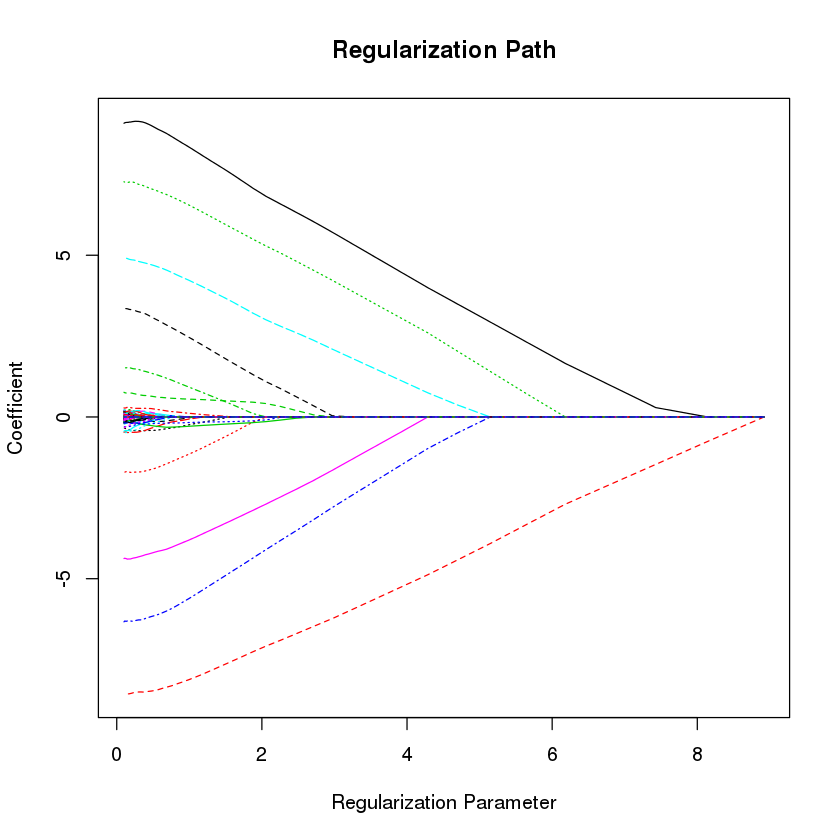

In [207]:
print(out4)
plot(out4)
# coef(out4)

In [244]:
slim.cv <- function(X, y, folds=10, method="lq", q=2,
                    lambda = NULL, nlambda = NULL, lambda.min.value = NULL, lambda.min.ratio = NULL,
                    rho = 1, res.sd = FALSE, prec = 1e-5, max.ite = 1e5, verbose = FALSE)
{
    # run on all all data to create lambda path
    initial.out <- slim(X, Y, lambda = lambda, nlambda = nlambda,
                         lambda.min.value = lambda.min.value,lambda.min.ratio = lambda.min.ratio,
                         rho = rho, method=method, q = q, res.sd = res.sd,
                         prec = prec, max.ite = max.ite, verbose = verbose)
    
    lambda_path <- initial.out$lambda
    
    # store cv mean swaure erros for each fold and lambda value
    df_cv_mse <- data.frame()
    df_cv_nz_beta <- data.frame()
    
    flds <- createFolds(Y, k = folds, list = TRUE, returnTrain = TRUE)
    N <- length(y)
    N_k <- N/folds
    for (fld in flds) {
        data_inds <- sample(1:N, N_k, replace = FALSE)
        
        X_train <- X[fld,]
        X_test <- X[-fld,]
        y_train <- y[fld]
        y_test <- y[-fld]
        
        slim.fld <- slim(X_train, y_train, lambda = lambda_path,
                         rho = rho, method=method, q = q, res.sd = res.sd,
                         prec = prec, max.ite = max.ite, verbose = verbose)
        
        predict.fld <- predict(slim.fld, X_test, lambda.idx = 1:length(lambda_path), verbose=FALSE)
        pred_mse_lambda <- colMeans(((predict.fld[[1]] - y_test)/length(y_test))^2)
        
        df_cv_mse <- rbind(df_cv_mse,pred_mse_lambda)
        df_cv_nz_beta <- rbind(df_cv_nz_beta,colSums(slim.fld$beta > 0))
    }
    
    mse_means <- apply(df_cv_mse, 2, mean)
    mse_sems <- apply(df_cv_mse, 2, sd)/sqrt(folds)
    
    nz_betas_means <- apply(df_cv_nz_beta, 2, mean)
    nz_betas_sems <- apply(df_cv_nz_beta, 2, sd)/sqrt(folds)
    
    summary_df <- data.frame('lambda'=lambda_path,
                             'MSE_mean'=mse_means,
                             'MSE_stdev'=mse_sems,
                             'Betas_nz_mean'=nz_betas_means,
                             'Betas_nz_stdev'=nz_betas_sems)
    rownames(summary_df) <- NULL
    return(summary_df)
}

cvout <- slim.cv(X,Y, nlambda=25, lambda.min.ratio=1, lambda.min.value = 0.01, method="lasso",q=2)

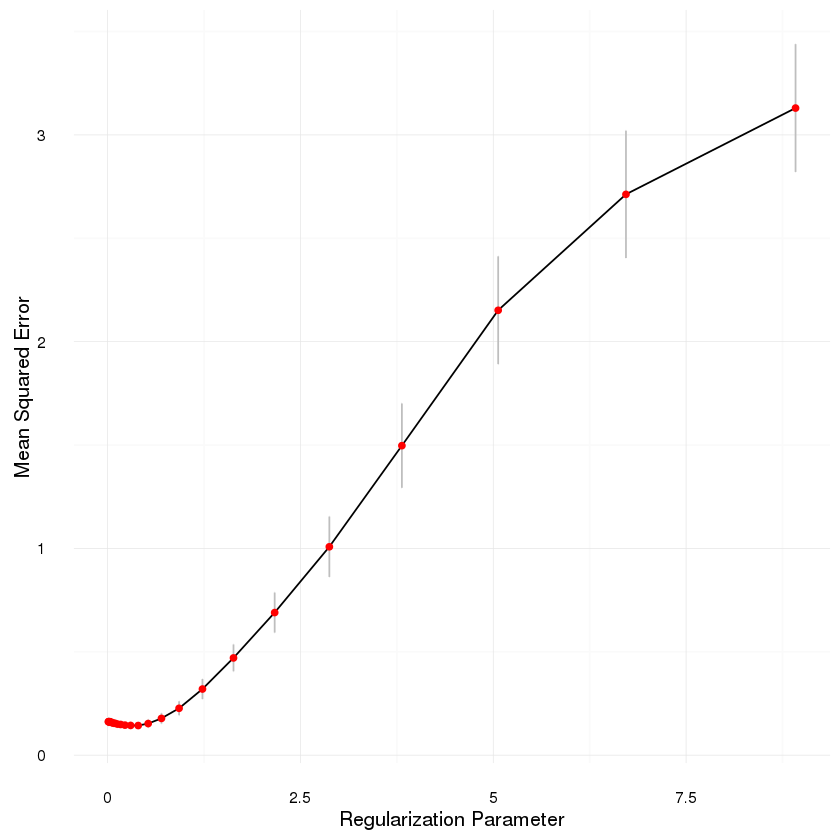

In [245]:
fmt <- function(){
  function(x) {
    d <- log10(min(diff(x),na.rm=TRUE))
    if(d < 0) format(x,nsmall = abs(round(d)),scientific = FALSE) else x
  }
}
      
ggplot(data=cvout, aes(x=lambda,y=MSE_mean)) + 
geom_errorbar( aes(ymax = MSE_mean + MSE_stdev, ymin=MSE_mean - MSE_stdev), colour = 'grey' ) +
geom_line() +
geom_point(color = 'red') +
scale_x_continuous(labels = fmt()) +
labs(x = 'Regularization Parameter', y = 'Mean Squared Error') +
theme_minimal()

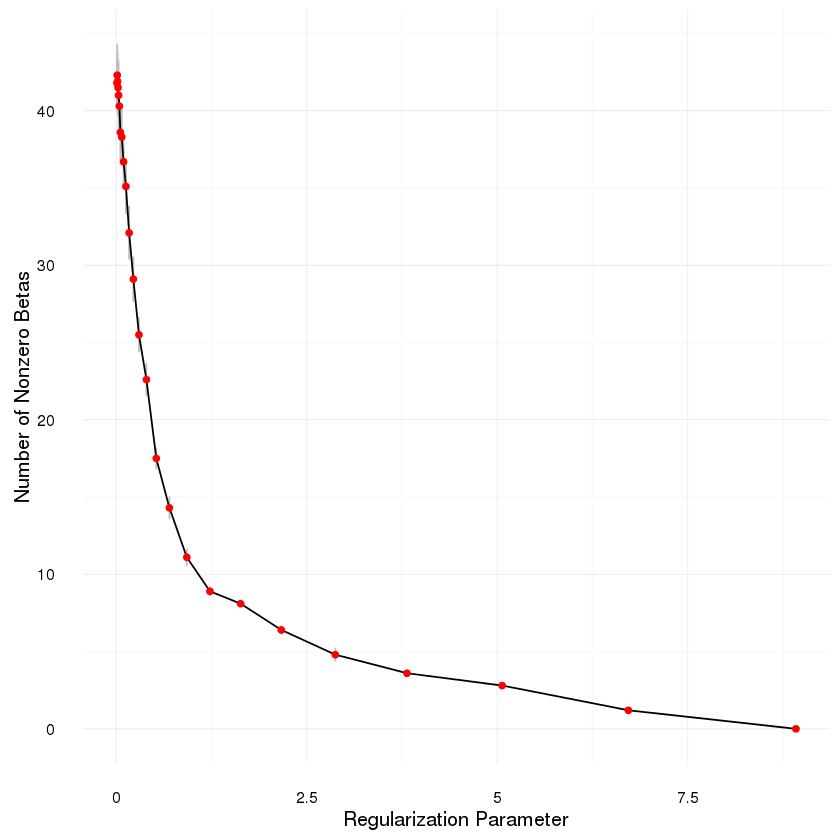

In [246]:
ggplot(data=cvout, aes(x=lambda,y=Betas_nz_mean)) + 
geom_errorbar( aes(ymax = Betas_nz_mean + Betas_nz_stdev, ymin=Betas_nz_mean - Betas_nz_stdev), colour = 'grey' ) +
geom_line() +
geom_point(color = 'red') +
scale_x_continuous(labels = fmt()) +
labs(x = 'Regularization Parameter', y = 'Number of Nonzero Betas') +
theme_minimal()

In [ ]:
## Mouse Data

In [247]:
data_dir <- "/users/rdonovan/shared_data/hd_mouse_allelic_series"
data_files_to_load <- list.files(path=data_dir)

In [248]:
for (data_file in data_files_to_load) {
    full_data_path <- file.path(data_dir,data_file)
    print(full_data_path)
    load(full_data_path)
}

load('~/shared_data/hd_mouse_allelic_series/htg_gene_names.Rdata')

ls()

[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_LOG.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_NPN.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_RAW.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_tidy_LOG.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_tidy_NPN.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/all_mrna_data_tidy_RAW.Rdata"
[1] "/users/rdonovan/shared_data/hd_mouse_allelic_series/htg_gene_names.Rdata"


[1] "all_mrna_data_logp1"    "all_mrna_data_npn"      "all_mrna_data_npn_tidy"
 [4] "all_mrna_data_raw"      "all_mrna_data_raw_tidy" "bar"                   
 [7] "beta"                   "cvout"                  "d"                     
[10] "data_dir"               "data_file"              "data_files_to_load"    
[13] "eps"                    "fmt"                    "foo"                   
[16] "full_data_path"         "genesEntrez"            "genesNames"            
[19] "n"                      "nlamb"                  "out4"                  
[22] "out5"                   "package"                "packages"              
[25] "preds"                  "q"                      "quit"                  
[28] "ratio"                  "slim.cv"                "X"                     
[31] "Y"

In [249]:
wt_mice_inds <- (all_mrna_data_logp1$GenoType == 'WT')
all_mrna_data_logp1[wt_mice_inds,c('Genotyped.CAG')] <- 7
all_mrna_data_logp1[wt_mice_inds,c('Numeric.Q')] <- 7

table(all_mrna_data_logp1$Numeric.Q)


  7  20  80  92 111 140 175 
112  72  71  72  72  72  72 

In [250]:
metabolic_genes <- read.csv('/users/rdonovan/shared_data/CONVERTED_MOUSE_IDS.csv')
metabolic_genes_entrez <- metabolic_genes[,1] %>% lapply(as.character) %>% sapply(paste0, collapse="")
metabolic_gene_names <- genesNames[metabolic_genes_entrez]
metabolic_gene_names <- metabolic_gene_names[!is.na(metabolic_gene_names)]

metabolic_mrna_data_logp1 <- cbind(all_mrna_data_logp1[1:11],all_mrna_data_logp1[c(metabolic_gene_names)])
dim(metabolic_mrna_data_logp1)

[1]  543 1397

In [251]:
cortex_2_condition <- (metabolic_mrna_data_logp1$Tissue == "cortex") & (metabolic_mrna_data_logp1$Month == 2)
data_subset_cortex_2 <- metabolic_mrna_data_logp1[cortex_2_condition,]                  
dim(data_subset_cortex_2)

striatum_2_condition <- (metabolic_mrna_data_logp1$Tissue == "striatum") & (metabolic_mrna_data_logp1$Month == 2)
data_subset_striatum_2 <- metabolic_mrna_data_logp1[striatum_2_condition,]                  
dim(data_subset_striatum_2)

liver_2_condition <- (metabolic_mrna_data_logp1$Tissue == "liver") & (metabolic_mrna_data_logp1$Month == 2)
data_subset_liver_2 <- metabolic_mrna_data_logp1[liver_2_condition,]                  
dim(data_subset_liver_2)

cortex_6_condition <- (metabolic_mrna_data_logp1$Tissue == "cortex") & (metabolic_mrna_data_logp1$Month == 6)
data_subset_cortex_6 <- metabolic_mrna_data_logp1[cortex_6_condition,]                  
dim(data_subset_cortex_6)

striatum_6_condition <- (metabolic_mrna_data_logp1$Tissue == "striatum") & (metabolic_mrna_data_logp1$Month == 6)
data_subset_striatum_6 <- metabolic_mrna_data_logp1[striatum_6_condition,]                  
dim(data_subset_striatum_6)

liver_6_condition <- (metabolic_mrna_data_logp1$Tissue == "liver") & (metabolic_mrna_data_logp1$Month == 6)
data_subset_liver_6 <- metabolic_mrna_data_logp1[liver_6_condition,]                  
dim(data_subset_liver_6)

cortex_10_condition <- (metabolic_mrna_data_logp1$Tissue == "cortex") & (metabolic_mrna_data_logp1$Month == 10)
data_subset_cortex_10 <- metabolic_mrna_data_logp1[cortex_10_condition,]                  
dim(data_subset_cortex_10)

striatum_10_condition <- (metabolic_mrna_data_logp1$Tissue == "striatum") & (metabolic_mrna_data_logp1$Month == 10)
data_subset_striatum_10 <- metabolic_mrna_data_logp1[striatum_10_condition,]                  
dim(data_subset_striatum_10)

liver_10_condition <- (metabolic_mrna_data_logp1$Tissue == "liver") & (metabolic_mrna_data_logp1$Month == 10)
data_subset_liver_10 <- metabolic_mrna_data_logp1[liver_10_condition,]                  
dim(data_subset_liver_10)

[1]   56 1397

[1]   56 1397

[1]   56 1397

[1]   56 1397

[1]   96 1397

[1]   56 1397

[1]   56 1397

[1]   56 1397

[1]   55 1397

In [252]:
my_data_subset <- data_subset_striatum_6

In [268]:
## generate data
n = 96
d = 1386
X = matrix(rnorm(n*d), n, d)
beta = c(10,-9,8,-7,6,-5,4,-3,2,-1,rep(0,d-10))
eps = rnorm(n)
y = X%*%beta + 2*eps
nlamb = 25
ratio = 0.3

In [282]:
# out1 = slim(X=X,Y=Y,nlambda=nlamb,lambda.min.ratio=ratio,method="dantzig")
# out2 = slim(X=X,Y=Y,nlambda=nlamb,lambda.min.ratio=ratio,method="lq",q=1)
# out3 = slim(X=X,Y=Y,nlambda=nlamb,lambda.min.ratio=ratio,method="lq",q=1.5)
# out4 = slim(X=X,Y=Y,nlambda=nlamb,lambda.min.ratio=ratio,method="lq",q=2)
# out5 = slim(X=X,Y=Y,nlambda=nlamb,lambda.min.ratio=ratio,method="lasso")

out4 = slim(X=X,Y=y, nlambda = 25, method="lasso")

Sparse Linear Regression with L1 Regularization.
Lasso with screening.

slim options summary: 
25 lambdas used:
 [1] 21.500 17.900 15.000 12.500 10.400  8.670  7.230  6.030  5.030  4.190
[11]  3.500  2.920  2.430  2.030  1.690  1.410  1.170  0.980  0.817  0.681
[21]  0.568  0.474  0.395  0.329  0.275
Method = lasso 
Degree of freedom: 1 -----> 93 
Runtime: 1.33127 mins 


In [283]:
out4$lambda

[1] 21.5215095 17.9449804 14.9628130 12.4762339 10.4028842  8.6740920
 [7]  7.2325973  6.0306558  5.0284577  4.1928088  3.4960314  2.9150471
[13]  2.4306131  2.0266843  1.6898819  1.4090507  1.1748891  0.9796414
[19]  0.8168408  0.6810949  0.5679079  0.4735307  0.3948375  0.3292219
[25]  0.2745105

In [289]:
str(X)

 num [1:96, 1:1386] -1.4936 1.2116 0.0721 -0.1595 1.0194 ...


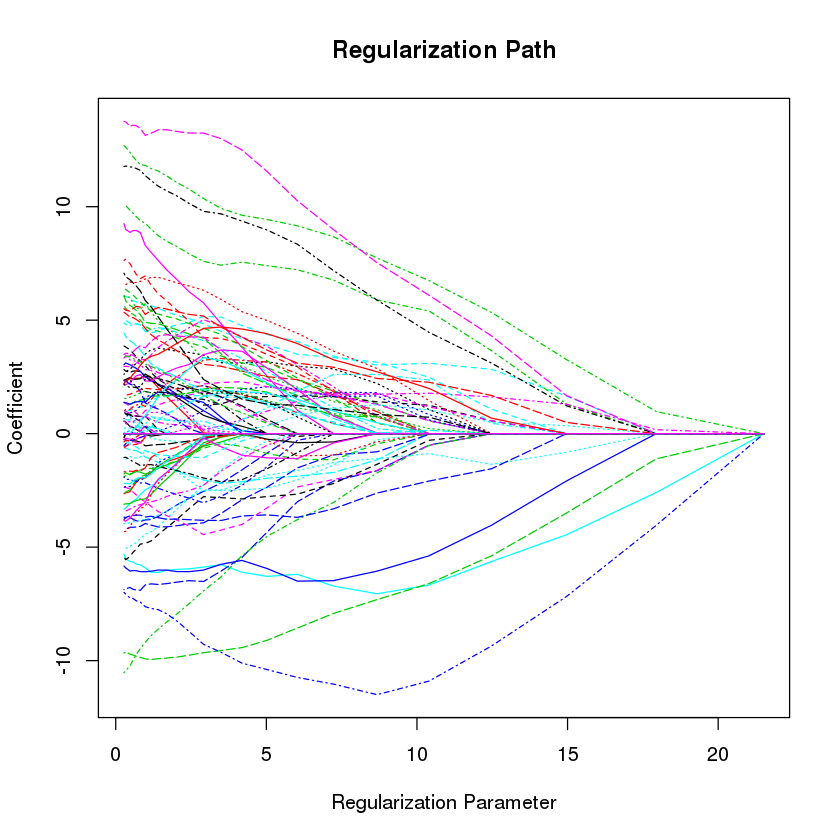

In [285]:
plot(out4)

In [300]:
y <- my_data_subset$Genotyped.CAG
y_q <- my_data_subset$Numeric.Q
X <- as.matrix(my_data_subset[-c(1:11)])
rownames(X) <- NULL
X_npn <- huge.npn(X)
length(y)
dim(X_npn)

Conducting the nonparanormal (npn) transformation via shrunkun ECDF....done.


[1] 96

[1]   96 1386

In [301]:
X_npn <- unname(X_npn)

In [302]:
str(X_npn)

 num [1:96, 1:1386] -1.032 -0.486 1.254 -0.257 0.742 ...


In [309]:
out.htg <- slim(X=X,Y=y)

Sparse Linear Regression with L1 Regularization.


ERROR: Error in if (lambda.max < lambda.min.value) {: missing value where TRUE/FALSE needed
